In [1]:
from cf_units import Unit
import re
import iris
%matplotlib inline
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats

In [2]:
def middle_wallop(t, tdmax, vmax, k=2, c=0, wind_const=2):
    delta_t = tdmax - t
    if _delta_t == 0:
        vis = vmax / 2
    if delta_t > 0:
        vis = (vmax / wind_const) / (k ** delta_t)
    elif delta_t < 0:
        vis = None
    return vis

In [3]:
temperatures  = range(0,10)
print temperatures
vmax = 20000.
tdmax = 8.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [4]:
visibilities = [middle_wallop(t, tdmax, vmax) for t in temperatures]
print visibilities

[78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0, 10000.0, 10000.0, 10000.0]


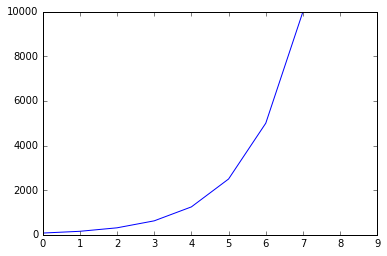

In [5]:
plt.plot(temperatures ,visibilities)

In [6]:
def process_temperatures(raw):
    temps = raw.split(' ')
    out = []
    for temp in temps:

        if int(temp[1]) == 0:
            out.append(float(temp[2:]) * 1. / 10)
        elif int(temp[1]) == 1:
            out.append(float(temp[2:]) * -1. / 10)
    return out

def process_visibilities(raw):
    raw = int(raw)
    if raw < 56:
        return raw * 100
    elif raw < 81:
        return (raw - 50) * 1000
    else:
        return 30000
    
def process_datetime(raw):
    raw = raw.split(',')
    raw = [int(i) for i in raw]
    return dt.datetime(*raw)

def process_windcloud(raw):
    try:
        out = [int(raw[0]), int(raw[1:3])*10, int(raw[3:5])]
    except:
        out = [9, int(raw[1:3])*10, int(raw[3:5])]
    return out

In [292]:
fh = open('xe_synops.txt')
dodgy = []
dave = fh.readlines()

regstr = ("03257,([0-9]{4},[0-9]{2},[0-9]{2},[0-9]{2},[0-9]{2}).*"
          "03257 [0-9|\/]{3}([0-9|\/]{2}) ([0-9|\/]{5}).*(1[0-1][0-9]{3} 2[0-1][0-9]{3}).*")
obs = []
linecount = 0
for line in dave:
    linecount += 1
    ob = {}
    try:
        ob['timestamp'] = process_datetime(re.match(regstr, line).group(1))
        ob['totalcloud'] = process_windcloud(re.match(regstr, line).group(3))[0]
        ob['winddir'] = process_windcloud(re.match(regstr, line).group(3))[1]
        ob['windspeed'] = process_windcloud(re.match(regstr, line).group(3))[2]
        ob['vis'] = process_visibilities(re.match(regstr, line).group(2))
        ob['dry_bulb'] = process_temperatures(re.match(regstr, line).group(4))[0]
        ob['dew_point'] = process_temperatures(re.match(regstr, line).group(4))[1]
        ob['error'] = False
    except:
        dodgy.append(line)
        ob['error'] = [line]
        try:
            ob['timestamp'] = process_datetime(re.match(regstr, line).group(1))
        except:
            #print "time error"
            pass
            #ob['error'].append('timestamp')
        try:
            ob['totalcloud'] = process_windcloud(re.match(regstr, line).group(3))[0]
            ob['winddir'] = process_windcloud(re.match(regstr, line).group(3))[1]
            ob['windspeed'] = process_windcloud(re.match(regstr, line).group(3))[2]
        except:
            #print "cloudwind error"
            pass
            #ob['error'].append('cloudwind')
        try:
            ob['vis'] = re.match(regstr, line).group(2)
        except:
            #print "vis error"
            pass
            #ob['error'].append('vis')
        try:
            ob['dry_bulb'] = process_temperatures(re.match(regstr, line).group(4))[0]
            ob['dew_point'] = process_temperatures(re.match(regstr, line).group(4))[1]
        except:
            #print "temperature error"
            pass
            #ob['error'].append('temperatures')
        pass
    obs.append(ob)

    
print len(dodgy)
# Remove all obs with an error flag or len==0
dirty_obs = obs
obs = []
bad = 0
for ob in dirty_obs:
    if len(ob)  == 0:
        pass
    elif ob['error'] != False:
        bad += 1
        pass
        
    else:
        obs.append(ob)

366


In [253]:
for ob in obs:
    if ob['error']:
        print ob

print "{} obs thrown away for being unparsable".format(bad)
print "{} obs in remaining in the list of obs".format(len(obs))
print "{} lines in input file".format(linecount)
firsttime = obs[0]['timestamp']
lasttime = obs[-1]['timestamp']
duration = lasttime - firsttime
hours = duration.days * 24 + duration.seconds / 3600
print "{} hours represented by the duration between first and last time stamps".format(hours)
print "{} missing obs amounting to {}% of the total".format(hours - linecount,
                                                            (hours - linecount) * 100 / hours)

367 obs thrown away for being unparsable
69049 obs in remaining in the list of obs
69416 lines in input file
70127 hours represented by the duration between first and last time stamps
711 missing obs amounting to 1% of the total


Divvy the data up into days with 14Z in both days.

In [254]:
# get a set of dates
set_of_dates = set([ob['timestamp'].date() for ob in obs])
days = {}
for date in set_of_dates:
    days[date] = {}
    for ob in obs:
        if ob['timestamp'].date() == date:
            days[date][ob['timestamp'].time()] = ob



In [255]:
# Check for days that do not have 24(!) hours
new_days = {}
for day, hours in days.iteritems():
    if len(hours) == 24:
        new_days[day] = hours
days = new_days
print ("After removing days that do not have the correct set "
      "of hours there are {} day(s) left".format(len(days)))

After removing days that do not have the correct set of hours there are 2331 day(s) left


In [296]:
# Create a dictionary of nights for the purpose of the investigation

# get a set of dates
set_of_dates = list(set([ob['timestamp'].date() for ob in obs]))
# This was required to allow the inclusion of the early hours of the first of Jan 2000
# which for our purposes come under the 31 December 1999
set_of_dates.append(min(set_of_dates) - dt.timedelta(days=1))
nighthours = {dt.time(hour): {} for hour in range(0,24)}
nights = {date: {} for date in set_of_dates}
for ob in obs:
    x = ob['timestamp']
    yesterday = x - dt.timedelta(days=1)
    if x.time().hour > 13:
        nights[x.date()][x.time()] = ob
    if x.time().hour <= 13:
        nights[yesterday.date()][yesterday.time()] = ob
                
# Uncomment this code for a printout of nights
# for night, hours in nights.iteritems():
#     print night
#     for hour, ob in hours.iteritems():
#         try:
#             print "| {} | {} | {} |".format(night, hour, ob['timestamp'])
#         except:
#             print "| {} | {} | {} |".format(night, hour, ob)
#     print "-"*10

In [297]:
def check_day_length(days, correct_countof_hours):
    new_nights = {}
    for night, hours in nights.iteritems():
        if len(hours) > 20:
            new_nights[night] = hours
    return new_nights

before = len(nights)
nights = check_day_length(nights, 24)
after = len(nights)
msg =("Before checking for 20 + Hour nights there were {} nights"
      "\nAfterwards there were {} nights\n"
      "so {} nights have been discarded")
print msg.format(before, after, before - after)

Before checking for 20 + Hour nights there were 2923 nights
Afterwards there were 2838 nights
so 85 nights have been discarded


Filter the days by lack of change in dewpoint - hopefully an indication of airmass.

In [298]:
def filter_by_dewpoint_non_change(days, precision=1.0):
    """
    Inputs
        days (dict)
            Takes a dictionary of days to filter
        precision (float)
            The precision in Kelvin to filter by
    
    Returns
        days (dict)
    """
    days_no_change = {}
    for day, hours in days.iteritems():
        for hour, ob in hours.iteritems():
            if hour.hour == 14:
                start = ob['dew_point']
            if hour.hour == 13:
                end = ob['dew_point']
        if abs(start - end) < precision:
            days_no_change[day] = hours
        
    return days_no_change



before = len(nights)
nights = filter_by_dewpoint_non_change(nights, 1.)
after = len(nights)
msg =("Before checking for dewpoint non change nights there were {} nights"
      "\nAfterwards there were {} nights\n"
      "so {} nights have been discarded")
print msg.format(before, after, before - after)

Before checking for dewpoint non change nights there were 2838 nights
Afterwards there were 726 nights
so 2112 nights have been discarded


For each hour calculate the Middle Wallop predicted visibility, based on current temperature and 14Z dew-point and visibility.

In [303]:
# And, Finally! Calculate the MW forecast vis for each day.
for night, hours in nights.iteritems():
    for hour, ob in hours.iteritems():
        if hour.hour == 14:
            tdmax = ob['dew_point']
            vmax = ob['vis']
        mw_vis = middle_wallop(ob['dry_bulb'],
                           tdmax,
                           vmax)
        ob.update({'fc_vis': mw_vis})

# Analysis of the data

## Plotting the data unfiltered
Initially we start by just plotting everything - which is a bit overwhealming, and shows almost no correlation:

we have 726 nights in our dataset
correlation  0.211608066137
sample size is 7853


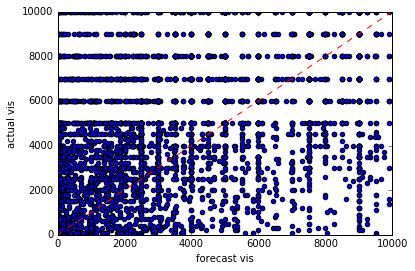

In [331]:
def days_plotter(days):
    plt.clf()
    actuals = []
    forecasts = []
    for day, hours in days.iteritems():
        for hour, ob in hours.iteritems():
            if ob['fc_vis'] and ob['fc_vis'] < 10000:
                actuals.append(ob['vis'])
                forecasts.append(ob['fc_vis'])

    plt.scatter(forecasts, actuals)
    maxv = 10000
    plt.xlim(0,maxv)
    plt.ylim(0,maxv)
    plt.plot([0, maxv], [0,maxv], 'r--')
    plt.xlabel('forecast vis')
    plt.ylabel('actual vis')
    print "correlation ", stats.pearsonr(forecasts, actuals)[0]
    print "sample size is {}".format(len(forecasts))
    

print "we have {} nights in our dataset".format(len(nights))
days_plotter(nights)

It should be noted that there is a distinct quantization of visibilities around vis points.

As a control I have plotted lowest visibility in the data against V at 14Z which, perhaps unsurprisingly shows that the overnight min vis will always be lower than the 14Z vis. It also has a rather stronger correlation. 

correlation  0.501357416071
sample size is 714


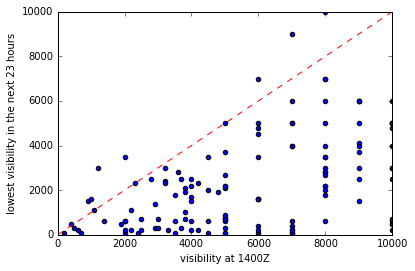

In [332]:
def vmin_max_corr_plot(days):
    vmax = []
    vmin = []
    for day, hours in days.iteritems():
        y = 100000.
        for hour, ob in hours.iteritems():
            if hour.hour == 14:
                x = ob['vis']
            elif ob['vis'] < y:
                y = ob['vis']
        if x and y:
            vmax.append(x)
            vmin.append(y)

    plt.scatter(vmax, vmin)
    maxv = 10000
    plt.xlim(0,maxv)
    plt.ylim(0,maxv)
    plt.plot([0, maxv], [0,maxv], 'r--')
    plt.xlabel('visibility at 1400Z')
    plt.ylabel('lowest visibility in the next 23 hours')
    print "correlation ", stats.pearsonr(vmax, vmin)[0]
    print "sample size is {}".format(len(vmax))

vmin_max_corr_plot(nights)

## Filtered by looking for nearly radiation nights:
    Realistically this method is only used when the forecaster is expecting skies to be clear overnight so we filter our data by skies with nearly cloudless nights:

correlation  0.387212442699
sample size is 1532


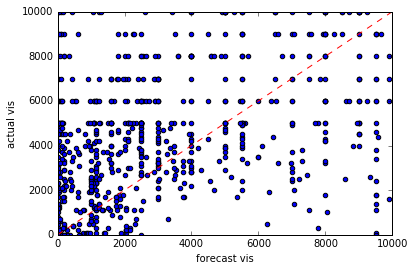

In [333]:
def filter_by_radiation_nights(days, cutoff=5):
    """
    Inputs
        days (dict)
            Takes a dictionary of days to filter
        cutoff (int)
            number of hours where the cloud cover can be > 2 okta
            before declaring the night "not a radiation night"
    Returns
        days (dict)
    """
    days_radiation = {}
    
    for day, hours in days.iteritems():
        score = 0
        for hour, ob in hours.iteritems():
            if ob['totalcloud'] > 2 and ob['totalcloud'] != 9:
                score += 1
        if score < cutoff:
            days_radiation[day] = hours
        
    return days_radiation

days_plotter(filter_by_radiation_nights(nights, cutoff=5))

# for night, hours in filter_by_radiation_nights(nights, cutoff=40).iteritems():
#     print night
#     for hour, ob in hours.iteritems():
#         print "| {} | {} | {} |".format(night, hour, ob['totalcloud'])

    This is clearly slightly better, although the criteria used are so arbitary that it's questionable how meaningful this is.
    
## Filter by wind direction
At Leeming it is uncommon to use this method for any wind direction other than SE'ly

correlation  0.37597836312
sample size is 961


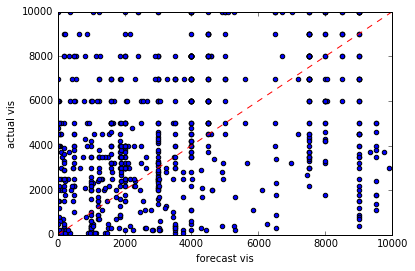

In [340]:
def filter_by_se_wind(days, cutoff=3):
    """
    Inputs
        days (dict)
            Takes a dictionary of days to filter
        cutoff (int)
            number of hours where the cloud cover can be > 2 okta
            before declaring the night "not a radiation night"
    Returns
        days (dict)
    """
    days_se = {}
    
    for day, hours in days.iteritems():
        score = 0
        for hour, ob in hours.iteritems():
            if ob['winddir'] < 90 or ob['winddir'] > 180:
                score += 1
        if score < cutoff:
            days_se[day] = hours
        
    return days_se

days_plotter(filter_by_se_wind(nights, cutoff=5))

In [412]:
perfect_nights = filter_by_se_wind(nights, cutoff=3)
perfect_nights = filter_by_radiation_nights(perfect_nights, cutoff=5)
len(perfect_nights)
#days_plotter(perfect_nights)
hours_template = range(14,23) + range(0,13)
night = perfect_nights[[night for night, hours in perfect_nights.iteritems()][0]]

egobs = [ob for hours, ob in night.iteritems()]

t = [ob['timestamp'] for ob in egobs]
vis = [ob['vis'] for ob in egobs]
fc_vis = [ob['fc_vis'] for ob in egobs]
print egobs

[{'dew_point': 11.5, 'fc_vis': 15000.0, 'timestamp': datetime.datetime(2006, 9, 30, 15, 50), 'winddir': 150, 'vis': 18000, 'windspeed': 6, 'dry_bulb': 16.3, 'error': False, 'totalcloud': 9}, {'dew_point': 12.9, 'fc_vis': 15000.0, 'timestamp': datetime.datetime(2006, 10, 1, 5, 50), 'winddir': 160, 'vis': 6000, 'windspeed': 8, 'dry_bulb': 14.0, 'error': False, 'totalcloud': 9}, {'dew_point': 12.4, 'fc_vis': 15000.0, 'timestamp': datetime.datetime(2006, 10, 1, 7, 50), 'winddir': 150, 'vis': 9000, 'windspeed': 7, 'dry_bulb': 13.5, 'error': False, 'totalcloud': 9}, {'dew_point': 11.9, 'fc_vis': 15000.0, 'timestamp': datetime.datetime(2006, 9, 30, 17, 50), 'winddir': 120, 'vis': 17000, 'windspeed': 2, 'dry_bulb': 15.2, 'error': False, 'totalcloud': 9}, {'dew_point': 12.8, 'fc_vis': 15000.0, 'timestamp': datetime.datetime(2006, 10, 1, 4, 50), 'winddir': 150, 'vis': 7000, 'windspeed': 6, 'dry_bulb': 13.7, 'error': False, 'totalcloud': 9}, {'dew_point': 11.4, 'fc_vis': 8000.0, 'timestamp': date

(732584.5833333334, 732585.5763888889)

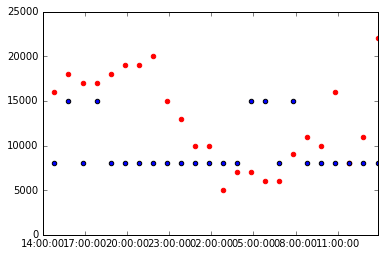

In [413]:
plt.scatter(t, vis, color='red')
plt.scatter(t, fc_vis)
plt.xlim(dt.datetime(2006, 9, 30, 14, 0), dt.datetime(2006, 10, 1, 13, 50))